In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import os
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
from torch.utils.data import DataLoader

In [ ]:
from google.colab import drive
drive.mount('/amd/')

Mounted at /amd/


In [ ]:
!cp /amd/My\ Drive/ODIR-5K.zip /content/

In [ ]:
!unzip ODIR-5K.zip

Streaming output truncated to the last 5000 lines.
  inflating: ODIR-5K/ODIR-5K/Training Images/2374_left-N.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/264_right-N.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/4246_left-D.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/3986_left-D&H&X.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/4658_right-D.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/3010_right-N.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/1869_left-A.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/4339_left-D.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/139_right-D&H&X.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/746_right-G&D&X.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/3336_right-N.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/287_left-O.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/1202_left-A&NaN&X.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/1623_left-M.jpg  
  inflating: ODIR-5K/ODIR-5K/Training Images/14

In [ ]:
#augmentation
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [ ]:
batch_size = 10
CLASS_NAMES = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

In [ ]:
import glob
import random

In [ ]:
!mkdir ODIR-5K/ODIR-5K/testing_Images

In [ ]:
all_paths = []
for element in glob.glob("/content/ODIR-5K/ODIR-5K/Validation_Images/*.jpg"):
  all_paths.append(element)

In [ ]:
num_to_select = 1000                          
list_of_random_items = random.sample(all_paths, num_to_select)
for element in list_of_random_items:
  p = element.split("/")
  os.replace(element, "ODIR-5K/ODIR-5K/testing_Images/"+p[-1])

In [ ]:
all_paths_testing=[]
for element in glob.glob("/content/ODIR-5K/ODIR-5K/testing_Images/*.jpg"):
  all_paths_testing.append(element)

In [ ]:
all_paths_training=[]
for element in glob.glob("/content/ODIR-5K/ODIR-5K/Training Images/*.jpg"):
  all_paths_training.append(element)

In [ ]:
all_paths_validation=[]
for element in glob.glob("/content/ODIR-5K/ODIR-5K/Validation_Images/*.jpg"):
  all_paths_validation.append(element)

In [ ]:
batchsize=10

In [ ]:
f= open("ODIR-5K/ODIR-5K/training.txt","w")
for i in all_paths_training:
  f.write(str(i)+"\n")
f= open("ODIR-5K/ODIR-5K/testing.txt","w")
for i in all_paths_testing:
  f.write(str(i)+"\n")
f= open("ODIR-5K/ODIR-5K/validation.txt","w")
for i in all_paths_validation:
  f.write(str(i)+"\n")

In [ ]:
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

In [ ]:
def get_label(name):
  parts = name.split("-")
  label = parts[-1].split(".")
  label = label[0]
  l = [0, 0, 0, 0, 0, 0, 0, 0]

  for e in label:
    if e != '&' and e != 'X':
      if e == 'N':
        l[0] = 1
      elif e == 'D':
        l[1] = 1
      elif e == 'G':
        l[2] = 1
      elif e == 'C':
        l[3] = 1
      elif e == 'A':
        l[4] = 1
      elif e == 'H':
        l[5] = 1
      elif e == 'M':
        l[6] = 1
      elif e == 'O':
        l[7] = 1

  return l

In [ ]:
class OCCULAR(Dataset):
  def __init__(self, root_dir,file_text, transform=None):
      
      self.root_dir = root_dir
      self.img_list = []
      self.label_list =[]
      with open(file_text) as f:
        lines = f.readlines()
        for i in range(len(lines)):
          self.img_list.append(lines[i].rstrip("\n"))
          self.label_list.append(get_label(lines[i]))
      self.transform = transform

  def __len__(self):
      return len(self.img_list)

  def __getitem__(self, idx):
      if torch.is_tensor(idx):
          idx = idx.tolist()

      img_path = self.img_list[idx]
      image = Image.open(img_path).convert('RGB')

      if self.transform:
          image = self.transform(image)
      sample = {'img': image,
                'label': self.label_list[idx][1]}
      return sample


In [ ]:
trainset = OCCULAR(root_dir='/content/ODIR-5K/ODIR-5K/Training Images',
                              file_text='/content/ODIR-5K/ODIR-5K/training.txt',
                              transform= train_transformer)
testset = OCCULAR(root_dir='/content/ODIR-5K/ODIR-5K/testing_Images',
                              file_text='/content/ODIR-5K/ODIR-5K/testing.txt',
                              transform= train_transformer)
validationset = OCCULAR(root_dir='/content/ODIR-5K/ODIR-5K/Validation_Images',
                              file_text='/content/ODIR-5K/ODIR-5K/validation.txt',
                              transform= train_transformer)

In [ ]:
print(trainset.__len__())
print(validationset.__len__())
print(testset.__len__())

train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
val_loader = DataLoader(validationset, batch_size=batchsize, drop_last=False, shuffle=False)
test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

4614
827
1000


In [ ]:
import numpy
import matplotlib.pyplot as plt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


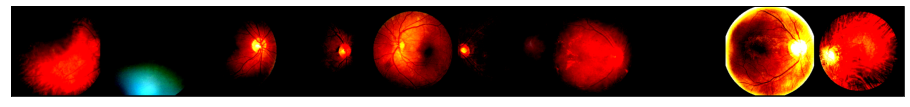

In [ ]:

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images['img'],nrow=16).permute(1,2,0))
        break
        
show_batch(train_loader)

In [ ]:
class EYE(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1,padding=1),
            # nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.MaxPool2d(5,5),# output: 50 x 50 x 64
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            # nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.MaxPool2d(5, 5), # output: 10 x 10 x 128
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            # nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.MaxPool2d(5, 5), #output 2*2*256
           
            nn.Conv2d(256,512, kernel_size=3, stride=1, padding=1),
            # nn.Conv2d(512,512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.MaxPool2d(2,2) #output 1*1*512
            )
        self.linear=nn.Sequential(
            nn.Flatten(),
            nn.Linear(512,64),
            nn.ReLU(),
            nn.Linear(64,8),
        )
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self,x):
      x = self.network(x)
      x=self.linear(x)
      x = self.softmax(x)
      return x
          
                

In [ ]:
device = torch.device("cuda")

In [ ]:
model = EYE()

# push the model to GPU
model = model.to(device)


In [ ]:
def evaluate():
  lambda1, lambda2 = 0.5, 0.01
  print("\nEvaluating...")
  model.eval()

  total_loss, total_accuracy = 0, 0
  total_preds = []
  for step,batch in enumerate(val_loader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_loader)))
    img, labels = batch['img'].cuda(),batch['label'].cuda()
    with torch.no_grad():
      preds = model(img)
      loss = cross_entropy(preds, labels) 
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)
  avg_loss = total_loss / len(val_loader) 
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
def fit(epochs,train_loader):
  best_loss = float('inf')
  for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds=[]
    for step,batch in enumerate(train_loader):
      if step % 50 == 0 and not step == 0:
        print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_loader)))
      img, labels = batch['img'].cuda(),batch['label'].cuda()
      model.zero_grad()        
      preds = model(img)
      loss = cross_entropy(preds, labels) 
      total_loss = total_loss + loss.item()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()
      preds=preds.detach().cpu().numpy()
      total_preds.append(preds)
    avg_loss = total_loss / len(train_loader)
    total_preds  = np.concatenate(total_preds, axis=0)
    print("\nEvaluating...")
    if avg_loss < best_loss:
        best_loss = avg_loss
        print("Saving")
        torch.save(model.state_dict(), 'saved_weights.pt')
        !cp -r saved_weights.pt /amd/My\ Drive
    print(f'\Loss: {avg_loss:.3f}')

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
from torch.utils.data import DataLoader, ConcatDataset
dataset =ConcatDataset([trainset,validationset,testset])

In [ ]:
k_folds = 5
epochs = 25
loss_function = nn.CrossEntropyLoss()
results = {}
torch.manual_seed(40)


kfold = KFold(n_splits=k_folds, shuffle=True)
print('--------------------------------')
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
  print(f'FOLD {fold}')
  print('--------------------------------')
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  train_loader = torch.utils.data.DataLoader(
                    dataset, 
                    batch_size=10, sampler=train_subsampler)
  test_loader = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=10, sampler=test_subsampler)
  fit(epochs,train_loader)
  test_correct=0
  test_loss = 0
  correct = 0
  results = []
  criteria = nn.CrossEntropyLoss()
  path = 'saved_weights.pt'
  model.load_state_dict(torch.load(path))

  model.eval()
  
  
  with torch.no_grad():
      tpr_list = []
      fpr_list = []
      
      predlist=[]
      scorelist=[]
      targetlist=[]
      for batch_index, batch_samples in enumerate(test_loader):
          if  batch_samples['label'].shape[0]%10!=0:
              continue 
          x_test , y_test = batch_samples['img'].cuda(), batch_samples['label'].cuda()
          output = model(x_test)
          test_loss += criteria(output, y_test.long())
         
          pred = output.argmax(dim=1, keepdim=True)
         
          test_correct += pred.eq(y_test.long().view_as(pred)).sum().item()
          rem=len(test_ids)%10
      print('\Fold set:{} \t Accuracy: {}/{} ({:.0f}%)\n'.format(fold,test_correct, len(test_ids)-rem,100.0 * test_correct / (len(test_ids)-rem)))

--------------------------------
FOLD 0
--------------------------------

 Epoch 1 / 25


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  Batch    50  of    516.
  Batch   100  of    516.
  Batch   150  of    516.
  Batch   200  of    516.
  Batch   250  of    516.
  Batch   300  of    516.
  Batch   350  of    516.
  Batch   400  of    516.
  Batch   450  of    516.
  Batch   500  of    516.

Evaluating...
Saving
\Loss: 0.624

 Epoch 2 / 25
  Batch    50  of    516.
  Batch   100  of    516.
  Batch   150  of    516.
  Batch   200  of    516.
  Batch   250  of    516.
  Batch   300  of    516.
  Batch   350  of    516.
  Batch   400  of    516.
  Batch   450  of    516.
  Batch   500  of    516.

Evaluating...
Saving
\Loss: 0.592

 Epoch 3 / 25
  Batch    50  of    516.
  Batch   100  of    516.
  Batch   150  of    516.
  Batch   200  of    516.
  Batch   250  of    516.
  Batch   300  of    516.
  Batch   350  of    516.
  Batch   400  of    516.
  Batch   450  of    516.
  Batch   500  of    516.

Evaluating...
Saving
\Loss: 0.583

 Epoch 4 / 25
  Batch    50  of    516.
  Batch   100  of    516.
  Batch   150  of 

In [ ]:
!cp /amd/My\ Drive/saved_weights.pt /content/

In [ ]:
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(test_loader):
            if batch_samples['label'].shape[0]%10!=0:
              continue
            data, target = batch_samples['img'].cuda(), batch_samples['label'].cuda()
            output = model(data)
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.long().view_as(pred)).sum().item()
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
        print('Accuracy: {}/{} ({:.0f}%)\n'.format(correct, len(test_loader.dataset)-3,100.0 * correct / (len(test_loader.dataset)-3)))
           
    return targetlist, scorelist, predlist

In [ ]:
model.load_state_dict(torch.load('/content/saved_weights.pt'))
targetlist, scorelist, predlist=test(model)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Accuracy: 810/997 (81%)



In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
accuracy = accuracy_score(targetlist, predlist)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(targetlist,predlist)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(targetlist, predlist)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(targetlist,predlist)
print('F1 score: %f' % f1)

Accuracy: 0.810000
Precision: 0.606965
Recall: 0.884058
F1 score: 0.719764
